# Sentiment Analysis on movie reviews using Naive Bayes

This project deals with movie review data that includes positive and negative reviews. Using the provided dataset, sentiment Analysis has been used to assess if a given review is positive or negative. Therefore, the Naive Bayes algorithm performs sentiment analysis on the movie review dataset.

# Importing the Libraries

In [ ]:
import numpy as np
import pandas as pd
import re
import nltk
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
import pickle
warnings.filterwarnings("ignore")

# Reading the data

In [ ]:
# Reading the data and removing columns that are not important

df = pd.read_csv("movie_reviews-1.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [ ]:
# Inspect the imported dataset

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,"Petter Mattei's ""Love in the Time of Money"" is...",positive
4,"Probably my all-time favorite movie, a story o...",positive


# Count plot of the output categories: positive or negative

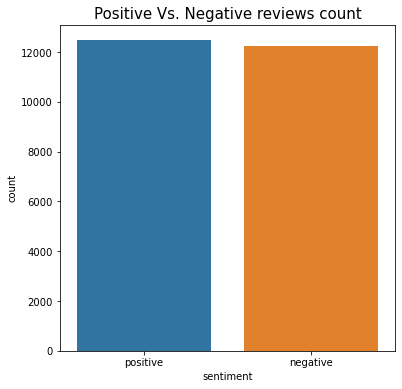

In [ ]:
plt.figure(figsize = (6,6))
sns.countplot(x="sentiment", data=df)
plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()

# Upsampling the minority class

It is known that Naive Bayes is not robust to class imbalance. It could be seen above that the data is a little imbalanced. Therefore, class balancing can be done before giving it to the Naive Bayes model for prediction.

In [ ]:
df_majority = df[df["sentiment"] == "positive"]
df_minority = df[df["sentiment"] == "negative"]

negative_upsample = resample(df_minority, replace = True, 
                        n_samples = df_majority.shape[0],
                        random_state = 101)

# Concat two data frames i.e majority class data set and upsampled minority class data set

df_upsampled = pd.concat([df_majority, negative_upsample])
df_upsampled = df_upsampled.sample(frac = 1)

In [ ]:
# Ensure that upsampling was done successfully

df_upsampled[df_upsampled["sentiment"]=="negative"].shape

(12474, 2)

In [ ]:
# Ensuring that the same number of data points are present for both 'positive' and 'negative' data

df_upsampled[df_upsampled["sentiment"]=="positive"].shape

(12474, 2)

In [ ]:
# Considering 10000 positive and 10000 negative data points

negative_data_points_train = df_upsampled[df_upsampled["sentiment"]=="negative"].iloc[:10000]
positive_data_points_train = df_upsampled[df_upsampled["sentiment"]=="positive"].iloc[:10000]

# Considering the remaining data points for test

negative_data_points_test = df_upsampled[df_upsampled["sentiment"]=="negative"].iloc[10000:]
positive_data_points_test = df_upsampled[df_upsampled["sentiment"]=="positive"].iloc[10000:]

# Concatenate the training positive and negative reviews

X_train = pd.concat([negative_data_points_train["review"], positive_data_points_train["review"]])

# Concatenating the training positive and negative outputs

y_train = pd.concat([negative_data_points_train["sentiment"], positive_data_points_train["sentiment"]])

# Concatenating the test positive and negative reviews

X_test = pd.concat([negative_data_points_test["review"], positive_data_points_test["review"]])

# Concatenating the test positive and negative outputs

y_test = pd.concat([negative_data_points_test["sentiment"], positive_data_points_test["sentiment"]])

In [ ]:
# Ensure that there are equal number of positive and negative reviews in the train data

y_train.value_counts()

negative    10000
positive    10000
Name: sentiment, dtype: int64

In [ ]:
# Ensure that there are equal number of positive and negative reviews in the test data

y_test.value_counts()

negative    2474
positive    2474
Name: sentiment, dtype: int64

# Pre-process the reviews

A review may contain links, punctuation, stopwords, and many other words that don't give a lot of meaning for the Naive Bayes model for prediction. In the cell below, I have implemented text-preprocessing and removed links, punctuations, and stopwords, along with converting the text to lowercase. In addition to this, I have performed a stemming operation so that similar words are reduced.

In [ ]:
# Function to clean the reviews

def clean_review(review):
    """
    Input:
        review: a string containing a review
    Output:
        review_cleaned: a processed review 
    """

    # removing punctuations
    
    step1 = "".join([i for i in review if i not in string.punctuation])
    
    # lowercase the letters
    
    step2 = "".join([i.lower() for i in step1])
    
    # removing special characters
    
    step3 = re.sub('[^A-Za-z0-9.]+', ' ', step2)
    
    # removing hyperlinks
    
    step4 = re.sub(r'http\S+', '', step3)

    # tokenizing words
    
    words = nltk.tokenize.word_tokenize(step4)
    
    # removing stopwords
    
    stopwords = nltk.corpus.stopwords.words('english')
    step5 = [i for i in words if i not in stopwords]
    
    # used lemmatization
    
    lemmatizer = WordNetLemmatizer()
    review_cleaned = [lemmatizer.lemmatize(word) for word in step5]
    review_cleaned = " ".join(review_cleaned)
    
    return review_cleaned

# Implement the find_occurrence function

In this function, the total occurrence of a word giving information such as label, word, and frequency dictionary is calculated. This function is used later in the code when we are going to be predicting the output using Naive Bayes.

In [ ]:
# Function to find the number of occurences of a given word

def find_occurrence(frequency, word, label):
    """
    Params:
        frequency: a dictionary with the frequency of each pair (or tuple)
        word: the word to look up
        label: the label corresponding to the word
    Return:
        n: the number of times the word with its corresponding label appears
    """

    n = 0
    pair = (word, label)
    if pair in frequency:
        n = frequency[pair]
  
    return n

# Converting output to numerical format

The outputs 'positive' or 'negative' are converted to a numerical format.

In [ ]:
# With the use of mapping function, the label in the form of string is replaced to an integer

output_map = {'positive': 0, 'negative': 1}
y_train = y_train.map(output_map)
y_test = y_test.map(output_map)

In [ ]:
# Ensuring that there are equal number of classes on the training data

y_train.value_counts()

1    10000
0    10000
Name: sentiment, dtype: int64

In [ ]:
# Choosing a random review and taking a look at it

X_train.iloc[0]

'I\'m sorry, but even TJ Hooker\'s Adrian Zmed couldn\'t save this sequel. I went through half the movie thinking that this was a spoof of the original. Then came that wild and wacky motorcycle scene (notice that this is the only movie that Patricia Birch directs); and I sadly realized they were trying to be serious. I did get a kick out of the fact that the opposing gang, having lost their "wheels" due to their gambling habits in the original Grease, were forced to use motorcycles in the second movie. Being shamed by that putz character Carrington, I\'d hate to see what they would resort to later: maybe Mopeds?<br /><br />I also never bought the hackneyed theme: hunky-Australian-boy-can\'t-fit-into-Outsiders-dominated-school-ergo-goes-for -tough-guy-with-stupid-biker-helmet-look. It was Disney story gone horribly awry.<br /><br />So, it looks like you CAN ruin a good thing by placing a bubble-gum smacking Michelle Pfeiffer in a musical. The only thing I took away from this movie was a

From the above cell output, it could be seen that there are a lot of words that don't add a lot of meaning to the text. Therefore, those words would be removed. It also reduces the computation time. Hence, cleaning the review is a good practice. The clean_review function is now used to pre-process the reviews and remove words that don't add a lot of meaning to our model.

In [ ]:
# Print a cleaned review to check the output

custom_review = X_train.iloc[0]
print(clean_review(custom_review))

im sorry even tj hooker adrian zmed couldnt save sequel went half movie thinking spoof original came wild wacky motorcycle scene notice movie patricia birch directs sadly realized trying serious get kick fact opposing gang lost wheel due gambling habit original grease forced use motorcycle second movie shamed putz character carrington id hate see would resort later maybe mopedsbr br also never bought hackneyed theme hunkyaustralianboycantfitintooutsidersdominatedschoolergogoesfor toughguywithstupidbikerhelmetlook disney story gone horribly awrybr br look like ruin good thing placing bubblegum smacking michelle pfeiffer musical thing took away movie idea many point ten give


# Implement the review_counter function

In this function, the occurrence of words is counted, and get the probabilities for the words are based on the training data. In other words, the probability of occurrence of a word is calculated, given that the output is 'positive'. Similarly, the probability of occurrence of a word is computed, given that the output is 'negative'.

In [ ]:
# Function to calculate the frequency of words

def review_counter(output_occurrence, reviews, positive_or_negative):
    """
    Params:
        output_occurrence: a dictionary that will be used to map each pair to its frequency
        reviews: a list of reviews
        positive_or_negative: a list corresponding to the sentiment of each review (either 0 or 1)
    Return:
        output: a dictionary mapping each pair to its frequency
    """

    for label, review in zip(positive_or_negative, reviews):
      split_review = clean_review(review).split()
      for word in split_review:
        if (word, label) in output_occurrence:
            output_occurrence[(word, label)] += 1
        else:
            output_occurrence[(word, label)] = 1
    
    return output_occurrence

# Test the above function using an example review

In [ ]:
# Testing the function

result = {}
reviews = ['got bored throught the moview', 'The movie was fantastic', 'Will not watch it again', 'Was bored, it was a complete waste of time and money', 'Enjoyed the movie to the fullest']
ys = [1, 0, 1, 1, 0]
review_counter(result, reviews, ys)

{('got', 1): 1,
 ('bored', 1): 2,
 ('throught', 1): 1,
 ('moview', 1): 1,
 ('movie', 0): 2,
 ('fantastic', 0): 1,
 ('watch', 1): 1,
 ('complete', 1): 1,
 ('waste', 1): 1,
 ('time', 1): 1,
 ('money', 1): 1,
 ('enjoyed', 0): 1,
 ('fullest', 0): 1}

In [ ]:
# Build the freqs dictionary for later uses

freqs = review_counter({}, X_train, y_train)

In [ ]:
# Get an idea about the corpus of words and their occurrence along with labels

freqs

{('im', 1): 2250,
 ('sorry', 1): 527,
 ('even', 1): 6187,
 ('tj', 1): 9,
 ('hooker', 1): 32,
 ('adrian', 1): 12,
 ('zmed', 1): 2,
 ('couldnt', 1): 880,
 ('save', 1): 663,
 ('sequel', 1): 468,
 ('went', 1): 680,
 ('half', 1): 933,
 ('movie', 1): 22389,
 ('thinking', 1): 567,
 ('spoof', 1): 128,
 ('original', 1): 1450,
 ('came', 1): 641,
 ('wild', 1): 119,
 ('wacky', 1): 28,
 ('motorcycle', 1): 35,
 ('scene', 1): 4508,
 ('notice', 1): 159,
 ('patricia', 1): 22,
 ('birch', 1): 4,
 ('directs', 1): 33,
 ('sadly', 1): 293,
 ('realized', 1): 134,
 ('trying', 1): 1285,
 ('serious', 1): 407,
 ('get', 1): 5209,
 ('kick', 1): 146,
 ('fact', 1): 1553,
 ('opposing', 1): 10,
 ('gang', 1): 235,
 ('lost', 1): 575,
 ('wheel', 1): 32,
 ('due', 1): 395,
 ('gambling', 1): 24,
 ('habit', 1): 58,
 ('grease', 1): 13,
 ('forced', 1): 323,
 ('use', 1): 750,
 ('second', 1): 863,
 ('shamed', 1): 8,
 ('putz', 1): 5,
 ('character', 1): 5655,
 ('carrington', 1): 4,
 ('id', 1): 613,
 ('hate', 1): 370,
 ('see', 1): 4

# Implement a function to train the Naive Bayes Model

In this cell, the log-likelihood and log prior values are calculated as these are important for testing. Also, the frequency of occurrence of words is calculated, where the output is negative. Similarly, the word frequency count using the above functions is calculated to compute the log-likelihood.

In [ ]:
# Function to train the Naive Bayes model

def train_naive_bayes(freqs, train_x, train_y):
    """
    Input:
        freqs: dictionary from (word, label) to how often the word appears
        train_x: a list of reviews
        train_y: a list of labels correponding to the reviews (0,1)
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    """

    loglikelihood = {}
    logprior = 0

    # calculate the number of unique words in the vocabulary

    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate the total number of positive and negative words for all documents

    num_pos = num_neg = 0
    for pair in freqs.keys():

        # if the label is zero

        if pair[1] == 0:

            # increment the number of positive words by the count for this (word, label) pair

            num_pos += freqs[pair]

        # else, the label is negative

        else:

            # increment the number of negative words by the count for this (word,label) pair

            num_neg += freqs[pair]

    # calculate the number of documents

    num_doc = len(train_y)

    # calculate the number of positive documents 

    pos_num_docs = len(list(filter(lambda x: x == 0, train_y)))

    # calculate the number of negative documents

    neg_num_docs = len(list(filter(lambda x: x != 0, train_y)))

    # calculate logprior

    logprior = np.log(neg_num_docs) - np.log(pos_num_docs)

    # for each word in the vocabulary

    for word in vocab:

        # get the positive and negative frequency of the word

        freq_pos = freqs[(word, 0)] if (word, 0) in freqs else 0
        freq_neg = freqs[(word, 1)] if (word, 1) in freqs else 0

        # calculate the probability that each word is positive, and negative

        p_w_pos = (freq_pos + 1) / (num_pos + V)
        p_w_neg = (freq_neg + 1) / (num_neg + V)

        # calculate the log likelihood of the word
        
        loglikelihood[word] = np.log(p_w_neg/p_w_pos)

    with open('local_file.pkl', 'wb') as f:
        pickle.dump([logprior, loglikelihood], f)

    return logprior, loglikelihood

In [ ]:
# Print the logprior and loglikelihood values

logprior, loglikelihood = train_naive_bayes(freqs, X_train, y_train)
print(logprior)
print(len(loglikelihood))

0.0
90725


# Implement the Naive Bayes predict function

After adding the log-likelihood values, the output is 1 (negative) if the sum of the log-likelihood value is greater than 0 and 0 (positive) if the sum of the log-likelihood is less than or equal to 0.

In [ ]:
# Function to predict the sentiment of a review using Naive Bayes

def naive_bayes_predict(review, logprior, loglikelihood):
    """
    Params:
        review: a string
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Return:
        total_prob: the sum of all the loglikelihoods of each word in the review (if found in the dictionary) + logprior (a number)
    """

    # process the review to get a list of words

    word_l = clean_review(review).split()

    # initialize probability to zero

    total_prob = 0

    # add the logprior

    total_prob = total_prob + logprior

    for word in word_l:

        # check if the word exists in the loglikelihood dictionary

        if word in loglikelihood:

            # add the log likelihood of that word to the probability
            
            total_prob = total_prob + loglikelihood[word]

    if total_prob>0:
        total_prob = 1
    else:
        total_prob = 0
    
    return total_prob

In [ ]:
# Experiment with an example review

my_review = "I thought this series was going to be another fun, action series with some dynamic plots and great performances. I was wrong. While I like Jamie Denton, this show is hardly worth watching at all, unless you enjoy watching some people brutalized and the actions of the agents supposedly warranted under the theme of national security. The show is great propaganda for the current government, and spews out jingoism as though we talk that way every day. After a couple of episodes, it was boring the hell out of me, and I started watching reruns of House Invaders on BBCAmerica instead. Rather watch CSI and Without a Trace, without a doubt."
p = naive_bayes_predict(my_review, logprior, loglikelihood)
print('The expected output is', p)

The expected output is 1


# Implement the Naive Bayes test function

In this function, the previous functions such as naive_bayes_predict are called, to get the predictions for the test set.  In addition to this, the function returns the total number of reviews that it correctly classified as 'positive' or 'negative'.

In [ ]:
# Function to implement the Naive Bayes test function

def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Input:
        test_x: A list of reviews
        test_y: the corresponding labels for the list of reviews
        logprior: the logprior
        loglikelihood: a dictionary with the loglikelihoods for each word
    Output:
        accuracy: (# of reviews classified correctly)/(total # of reviews)
    """

    accuracy = 0  
    y_hats = []
    
    for review in test_x:

        # if the prediction is > 0

        if naive_bayes_predict(review, logprior, loglikelihood):

            # the predicted class is 1

            y_hat_i = 1
        else:

            # otherwise the predicted class is 0

            y_hat_i = 0

        # append the predicted class to the list y_hats

        y_hats.append(y_hat_i)

    # error is the average of the absolute values of the differences between y_hats and test_y
    
    error = np.mean(np.absolute(y_hats - test_y))

    accuracy = 1 - error
    
    return accuracy, y_hats

In [ ]:
# Test the above function

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                    "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = naive_bayes_predict(review, logprior, loglikelihood)
    print(f'{review[:100]} -> {p:.2f}')

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 0.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 1.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 0.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 1.00


In [ ]:
# Experiment to check the sentiment of an example review

my_review = 'The moview was very boring, I wanted to leave in the middle'
naive_bayes_predict(my_review, logprior, loglikelihood)

1

# Evaluate the accuracy of the model

The following steps are executed:
1. The data is split into training and test sets using random selection
2. Model parameters are calculated with the training set
3. Print confusion matrix for training and test set

Accuracy:  90.02024291497975
Error:  9.979757085020246


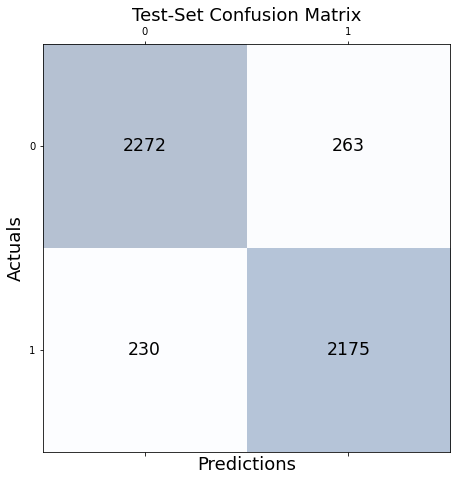

In [ ]:
# Step 1

train_x, test_x, train_y, test_y = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=2)
output_map = {'positive': 0, 'negative': 1}
train_y = train_y.map(output_map)
test_y = test_y.map(output_map)

# Step 2

logprior, loglikelihood = train_naive_bayes(freqs, train_x, train_y)
accuracy, y_hats = test_naive_bayes(test_x, test_y, logprior, loglikelihood)
print("Accuracy: ", accuracy*100)
print("Error: ", (1-accuracy)*100)

# Step 3

conf_matrix = confusion_matrix(y_true=test_y, y_pred=y_hats)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Test-Set Confusion Matrix', fontsize=18)
plt.show()

# Modularized the classifier

The following modularizations are made:
1. Code of this notebook is converted into a python module text_classifier.py
2. The user will be able to launch the application on the command prompt. The module will automatically load the model parameters from a local file local_file.pkl, and be ready to take the input from the user on the command prompt. The program will preprocess the input, and tokenize and predict the class
3. The module will take the input from the user and output the sentiment class in an indefinite loop. The output prints out the probabilities for each input token along with the final classification decision
4. Program will quit if the user enters X